In [2]:
# TODO (SHORT TERM) :
#    0 / Industrialiser
#    1 / Check predictions et data en input (y chelou, faire des value_counts sur les y considérés, en tester plusieurs, etc.)
#    2 / Prendre fichier Excel et importer / valider data et créer features au fur et à mesure
#    3 / De temps en temps, reteter algos

#    Conseil Guyguy : avec quel proba les prédiction sont effectuées ? C'est assez sûr ?
#    Improve algos
#    Jouer sur ce qu'on prédit (+10, -10, etc.) + échéance !
#    Jouer sur le Treshold, si je prédit peu d'événements mais avec certitude, intéressant aussi !

In [6]:
from utils_csa import show_model_accuracy

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split

# Lib to calcul financial indicators https://github.com/mrjbq7/ta-lib
import talib

# Lib to import ipynb : https://pypi.org/project/import-ipynb/
import import_ipynb
import algocryptos_preprocessing as alg_preproc

In [8]:
# ------------------ LOAD DATA FROM DATABASE ------------------ #
id_cryptocompare_ether = "7605"
df2 = alg_preproc.get_global_dataset_for_crypto(id_cryptocompare_ether)

-0.48319278494841644
0.6078558997778176
-0.00021198828031114358
-0.002382479511364382


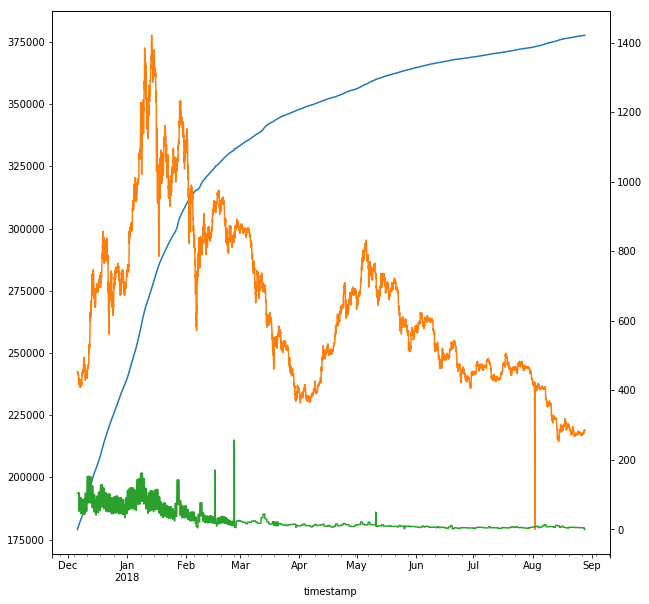

In [7]:
# ------------------ DATA VIZUALISATION ------------------ #

# correlations (to be done with y to be searched, here not interesting...)
#print(df.close_price.corr(df.reddit_subscribers))
#print(df.close_price.corr(df.reddit_subscribers_slope))
#print(df.close_price.corr(df.volume_aggregated))
#print(df.close_price.corr(df.volume_aggregated_slope))

In [9]:
# ------------------ PRE-PROCESSING : Splitting Data ------------------ #

# number of columns before adding y values
columns_nb = len(df2.columns)

def calcul_values_of_y(df, dict_hours_labels, increase_target_pct):
    increase_target_pct = increase_target_pct / 100
    
    for key in dict_hours_labels:
        label_value = 'y_+' + dict_hours_labels[key] + '_value'
        label_classif = 'y_+' + dict_hours_labels[key] + '_classif'
        # calcul several y searched (value)
        df[label_value] = df.close_price.shift(-key)
        
        # perform calcul to use binary classification
        df[label_classif] = ((df[label_value] - df['close_price']) / df['close_price']) > increase_target_pct
    
    return df

# calcul all y values we are interested in and add it to the dataframe
close_price_increase_targeted = +5
dict_hours_labels  = {6:'6h', 12:'12h', 24:'1d', 24*2:'2d', 24*3:'3d', 24*7:'7d', 24*15:'15d', 24*30:'30d'}
df3 = calcul_values_of_y(df2.copy(), dict_hours_labels, close_price_increase_targeted)

# remove rows where y can't be calculed (need more data in the future)
df3.dropna(subset=list(df3.iloc[:,range(columns_nb, len(df3.columns))]), inplace=True)

# separe x,y
X = df3.iloc[:,range(1, columns_nb)]
y = df3.iloc[:,range(columns_nb, len(df3.columns))]

# split data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=False)

In [11]:
# ------------------ PRE-PROCESSING : Scaling Data ------------------ #
# scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# ------------------ MODEL FITTING ------------------ #

# -----------------------
# ALGO : DUMMY CLASSIFIER
# -----------------------
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train['y_+1d_classif'])

show_model_accuracy('DummyClassifier - Train', dummy_clf, X_train_scaled, y_train['y_+1d_classif'], X_train.columns)
show_model_accuracy('DummyClassifier - Test', dummy_clf, X_test_scaled, y_test['y_+1d_classif'], X_test.columns)

----------------------------------------------------------
Results for algorithm : DummyClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3892    0]
 [ 965    0]]
Accuracy: 0.80
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.80      1.00      0.89      3892
       True       0.00      0.00      0.00       965

avg / total       0.64      0.80      0.71      4857

----------------------------------------------------------

----------------------------------------------------------
Results for algorithm : DummyClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1482    0]
 [ 138    0]]
Accuracy: 0.91
AUC: 0.50


Other Metrics :

             precision    recall  f1-score   support

      False       0.91      1.00      0.96      1482
       True       0.00      0.00      0.00       138

avg / total       0.84      0.91      0.87      1

C:\Users\cysac\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3417  475]
 [  83  882]]
Accuracy: 0.89
AUC: 0.90


Other Metrics :

             precision    recall  f1-score   support

      False       0.98      0.88      0.92      3892
       True       0.65      0.91      0.76       965

avg / total       0.91      0.89      0.89      4857

----------------------------------------------------------



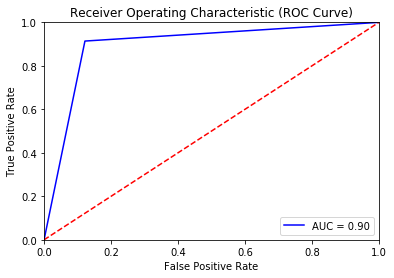

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1469   13]
 [ 121   17]]
Accuracy: 0.92
AUC: 0.56


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.99      0.96      1482
       True       0.57      0.12      0.20       138

avg / total       0.89      0.92      0.89      1620

----------------------------------------------------------



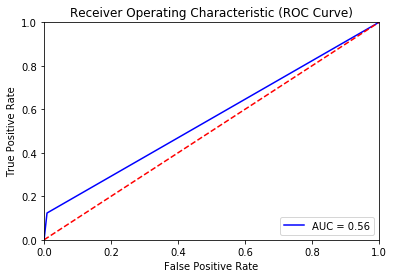

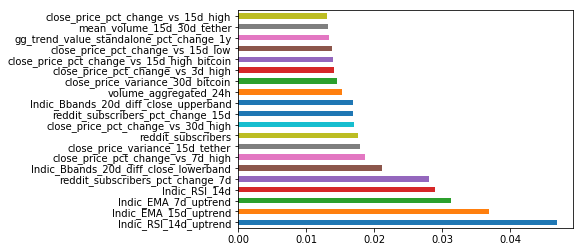

[0.15141161 0.17465232 0.21809794 ... 0.3604276  0.36157084 0.34963429]


In [24]:
# -----------------------
# ALGO : RANDOM FOREST
# -----------------------
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=250, random_state=0, max_features='auto', max_depth=5, class_weight="balanced").fit(X_train_scaled, y_train['y_+1d_classif'])

show_model_accuracy('RandomForestClassifier - Train', clf, X_train_scaled, y_train['y_+1d_classif'], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test_scaled, y_test['y_+1d_classif'], X_test.columns, do_roc_curve=True, do_features_importance=True)

# proba : to be shown by prediction, bien comprendre !
print(clf.predict_proba(X_test_scaled)[:,1])

----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Train
----------------------------------------------------------

Confusion Matrix :
 [[3417  475]
 [  83  882]]
Accuracy: 0.89
AUC: 0.90


Other Metrics :

             precision    recall  f1-score   support

      False       0.98      0.88      0.92      3892
       True       0.65      0.91      0.76       965

avg / total       0.91      0.89      0.89      4857

----------------------------------------------------------



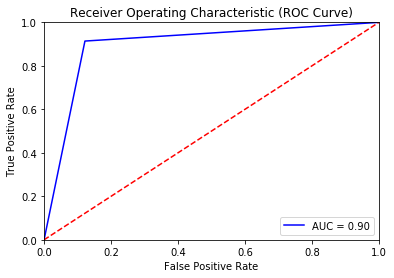

----------------------------------------------------------
Results for algorithm : NAIVE BAYES - GaussianNB - Test
----------------------------------------------------------

Confusion Matrix :
 [[1469   13]
 [ 121   17]]
Accuracy: 0.92
AUC: 0.56


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.99      0.96      1482
       True       0.57      0.12      0.20       138

avg / total       0.89      0.92      0.89      1620

----------------------------------------------------------



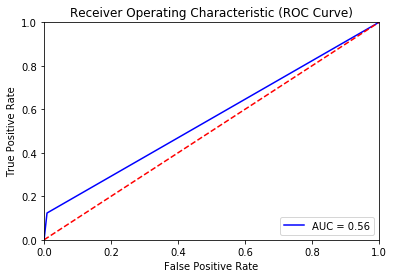

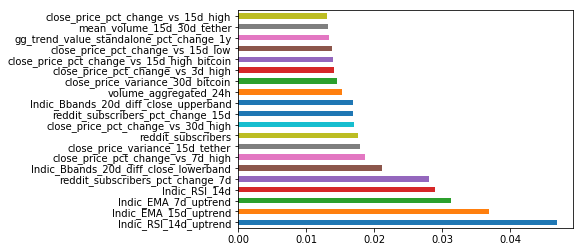

In [14]:
# -----------------------
# ALGO : NAIVE BAYES - GAUSSIANNB
# -----------------------
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train_scaled, y_train['y_+1d_classif'])

show_model_accuracy('NAIVE BAYES - GaussianNB - Train', clf, X_train_scaled, y_train['y_+1d_classif'], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('NAIVE BAYES - GaussianNB - Test', clf, X_test_scaled, y_test['y_+1d_classif'], X_test.columns, do_roc_curve=True, do_features_importance=True)


----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[3876   16]
 [ 202  763]]
Accuracy: 0.96
AUC: 0.89


Other Metrics :

             precision    recall  f1-score   support

      False       0.95      1.00      0.97      3892
       True       0.98      0.79      0.88       965

avg / total       0.96      0.96      0.95      4857

----------------------------------------------------------



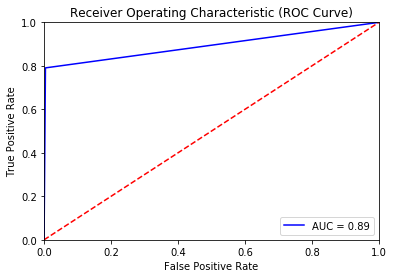

----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1416   66]
 [ 120   18]]
Accuracy: 0.89
AUC: 0.54


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.96      0.94      1482
       True       0.21      0.13      0.16       138

avg / total       0.86      0.89      0.87      1620

----------------------------------------------------------



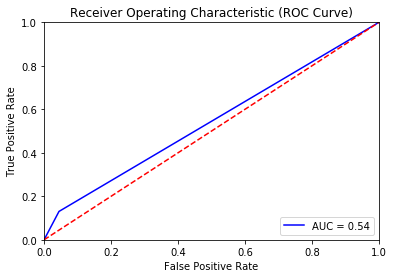

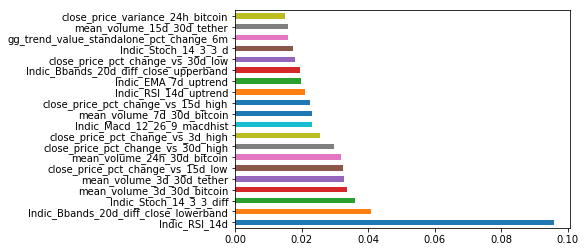

In [15]:
# -----------------------
# ALGO : GradientBoostingClassifier (cf. Module+4 for tuning)
# -----------------------
from sklearn.ensemble import GradientBoostingClassifier

#GradientBoostingClassifier(learning_rate = 0.02, max_depth = 5, random_state = 0)
clf = GradientBoostingClassifier().fit(X_train_scaled, y_train['y_+1d_classif'])

show_model_accuracy('GradientBoostingClassifier - Train', clf, X_train_scaled, y_train['y_+1d_classif'], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('GradientBoostingClassifier - Test', clf, X_test_scaled, y_test['y_+1d_classif'], X_test.columns, do_roc_curve=True, do_features_importance=True)

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Train
----------------------------------------------------------

Confusion Matrix :
 [[3818   74]
 [  88  877]]
Accuracy: 0.97
AUC: 0.94


Other Metrics :

             precision    recall  f1-score   support

      False       0.98      0.98      0.98      3892
       True       0.92      0.91      0.92       965

avg / total       0.97      0.97      0.97      4857

----------------------------------------------------------



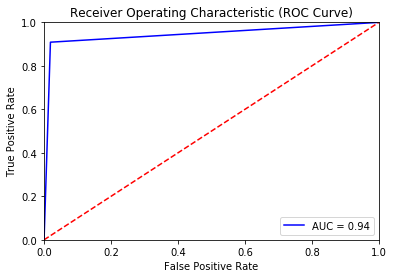

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Test
----------------------------------------------------------

Confusion Matrix :
 [[1305  177]
 [  62   76]]
Accuracy: 0.85
AUC: 0.72


Other Metrics :

             precision    recall  f1-score   support

      False       0.95      0.88      0.92      1482
       True       0.30      0.55      0.39       138

avg / total       0.90      0.85      0.87      1620

----------------------------------------------------------



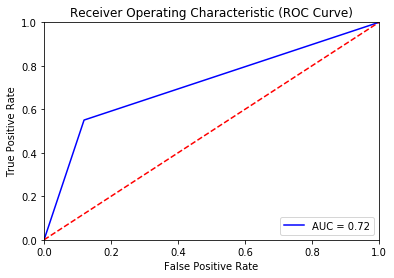

In [16]:
# -----------------------
# ALGO : MLPClassifier - Neural Network (cf. Module+4 for tuning)
# -----------------------
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [100, 100], solver='lbfgs',
                     random_state = 0).fit(X_train_scaled, y_train['y_+1d_classif'])

show_model_accuracy('MLPClassifier - Neural Network - Train', nnclf, X_train_scaled, y_train['y_+1d_classif'], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('MLPClassifier - Neural Network - Test', nnclf, X_test_scaled, y_test['y_+1d_classif'], X_test.columns, do_roc_curve=True, do_features_importance=False)

----------------------------------------------------------
Results for algorithm : SVM - Train
----------------------------------------------------------

Confusion Matrix :
 [[3778  114]
 [ 275  690]]
Accuracy: 0.92
AUC: 0.84


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.97      0.95      3892
       True       0.86      0.72      0.78       965

avg / total       0.92      0.92      0.92      4857

----------------------------------------------------------



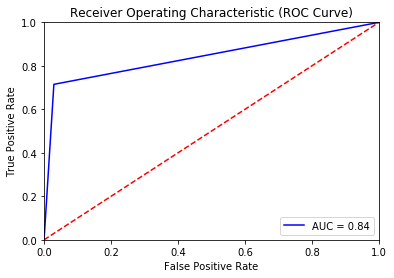

----------------------------------------------------------
Results for algorithm : SVM - Test
----------------------------------------------------------

Confusion Matrix :
 [[1277  205]
 [  89   49]]
Accuracy: 0.82
AUC: 0.61


Other Metrics :

             precision    recall  f1-score   support

      False       0.93      0.86      0.90      1482
       True       0.19      0.36      0.25       138

avg / total       0.87      0.82      0.84      1620

----------------------------------------------------------



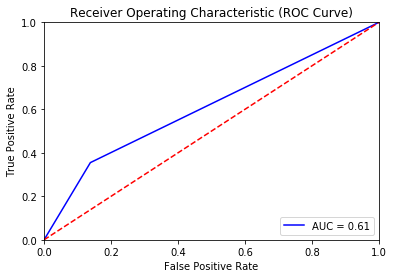

In [17]:
# -----------------------
# ALGO : SVC - (cf. Module+3 for tuning)
# -----------------------
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1).fit(X_train_scaled, y_train['y_+1d_classif'])


show_model_accuracy('SVM - Train', svm, X_train_scaled, y_train['y_+1d_classif'], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('SVM - Test', svm, X_test_scaled, y_test['y_+1d_classif'], X_test.columns, do_roc_curve=True, do_features_importance=False)